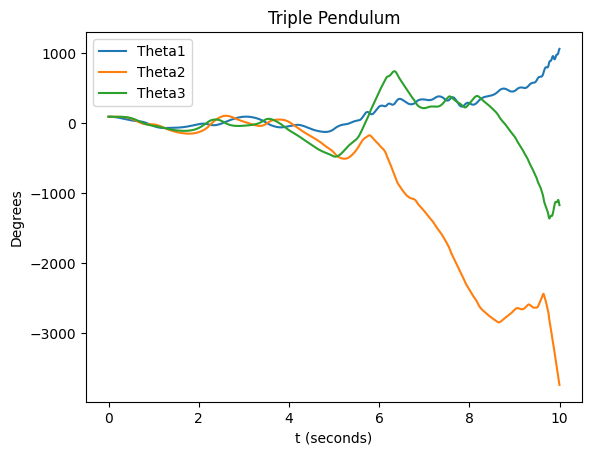

triple_pendulum_data_90_90_90.npy


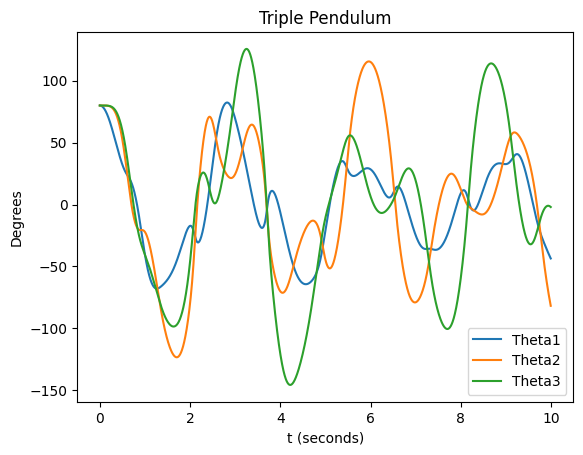

triple_pendulum_data_80_80_80.npy


In [34]:
from __future__ import division, print_function
from math import sin, pi
import numpy as np
from pylab import plot, xlabel, ylabel, show
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi, radians
from numpy import array, arange, zeros_like
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos, pi
from numpy import array

# Constants
g = 9.81  # Acceleration due to gravity
L1, L2, L3 = 1.0, 1.0, 1.0  # Lengths of pendulums
m1, m2, m3 = 1.0, 1.0, 1.0  # Masses of pendulums

def f(r, t):
    theta1, omega1, theta2, omega2, theta3, omega3 = r

    ftheta1 = omega1
    ftheta2 = omega2
    ftheta3 = omega3

    delta12 = theta1 - theta2
    delta13 = theta1 - theta3
    delta23 = theta2 - theta3

    denom1 = L1 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta13))
    denom2 = L2 * (2 * m1 + m2 + m3 - m2 * cos(2 * delta12) - m3 * cos(2 * delta23))
    denom3 = L3 * (2 * m1 + m2 + m3 - m3 * cos(2 * delta13))

    fomega1 = (-g * (2 * m1 + m2 + m3) * sin(theta1)
               - m2 * g * sin(theta1 - 2 * theta2)
               - m3 * g * sin(theta1 - 2 * theta3)
               - 2 * sin(delta12) * m2 * (omega2**2 * L2 + omega1**2 * L1 * cos(delta12))
               - 2 * sin(delta13) * m3 * (omega3**2 * L3 + omega1**2 * L1 * cos(delta13))) / denom1

    fomega2 = (2 * sin(delta12) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta12)
                                   + omega3**2 * L3 * m3 * cos(delta13))) / denom2

    fomega3 = (2 * sin(delta13) * (omega1**2 * L1 * (m1 + m2 + m3)
                                   + g * (m1 + m2 + m3) * cos(theta1)
                                   + omega2**2 * L2 * m2 * cos(delta23)
                                   + omega3**2 * L3 * m3 * cos(delta13))) / denom3

    return array([ftheta1, fomega1, ftheta2, fomega2, ftheta3, fomega3], float)

# Time parameters
a, b = 0.0, 10.0
N = 2000
h = (b - a) / N
tpoints = np.arange(a, b, h)

# Initial conditions (angles in degrees, converted to radians)
angles = [[90, 90, 90], [80, 80, 80]]

for x in angles:
    theta1_points = np.zeros_like(tpoints)
    theta2_points = np.zeros_like(tpoints)
    theta3_points = np.zeros_like(tpoints)

    # Initial angles (convert to radians)
    r = np.array([x[0] * pi / 180, 0, x[1] * pi / 180, 0, x[2] * pi / 180, 0], float)

    for i, t in enumerate(tpoints):
        theta1_points[i] = r[0] * 180 / pi
        theta2_points[i] = r[2] * 180 / pi
        theta3_points[i] = r[4] * 180 / pi

        # Runge-Kutta method
        k1 = h * f(r, t)
        k2 = h * f(r + 0.5 * k1, t + 0.5 * h)
        k3 = h * f(r + 0.5 * k2, t + 0.5 * h)
        k4 = h * f(r + k3, t + h)
        r += (k1 + 2 * k2 + 2 * k3 + k4) / 6

    plt.plot(tpoints, theta1_points, label='Theta1')
    plt.plot(tpoints, theta2_points, label='Theta2')
    plt.plot(tpoints, theta3_points, label='Theta3')
    plt.title("Triple Pendulum")
    plt.xlabel("t (seconds)")
    plt.ylabel("Degrees")
    plt.legend()
    plt.show()


    data = np.stack((theta1_points, theta2_points, theta3_points), axis=1)
    print(f'triple_pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy')
    np.save(f'triple_pendulum_data_{str(x[0])}_{str(x[1])}_{str(x[2])}.npy', data)



In [41]:
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from sklearn.metrics import mean_squared_error, r2_score

# Define the dataset class
class QuadraticDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)  # Shape (N, 2)
        self.y = torch.tensor(y, dtype=torch.float32)  # Shape (N, 2)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


data = np.load('triple_pendulum_data_80_80_80.npy')
print(data)
print(type(data))


# Normalize the data
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

# create the sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)



SEQ_LENGTH = 50
X, y = create_sequences(data, SEQ_LENGTH)


# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#LSTM class definition
class LSTM(nn.Module):
  def __init__(self, in_size, hidden_size, out_size, num_layers):
    super(LSTM, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(in_size, hidden_size, num_layers, batch_first=True)
    self.output = nn.Linear(hidden_size, out_size)

  def forward(self, X):
    hidden_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
    cell_states = torch.zeros(self.num_layers, X.size(0), self.hidden_size)
    lstm_out, _ = self.lstm(X, (hidden_states, cell_states))
    out = self.output(lstm_out[:, -1, :])
    return out

train_losses = []
val_losses = []

def train(model, num_epochs, train_loader, test_loader, loss_func, optimizer):
  val_best = float('inf')
  epoch_same = 0
  best_model = None
  for epoch in range(num_epochs):
    train_loss = 0
    model.train()
    for sequences, targets in train_loader:
      optimizer.zero_grad()

      y_pred = model(sequences)
      loss = loss_func(y_pred, targets)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
      for sequences, targets in test_loader:
        y_pred = model(sequences)
        loss = loss_func(y_pred, targets)
        val_loss += loss.item()
      val_loss /= len(test_loader)
      val_losses.append(val_loss)

    print(f"Epoch {epoch+1}; Training Loss {train_loss:.4f}; Validation Loss {val_loss:.4f}")

    if val_loss < val_best:
      val_best = val_loss
      epoch_same = 0
      best_model = model.state_dict()
    else:
      epoch_same += 1
    if epoch_same == 15:
      break

  if best_model:
    model.load_state_dict(best_model)

def evaluate(model, test_loader, loss_func):
  model.eval()
  eval_loss = 0
  inferences = []
  _targets = []

  with torch.no_grad():
    for sequences, targets in test_loader:
      y_pred = model(sequences)
      loss = torch.sqrt(loss_func(y_pred, targets))
      eval_loss += loss.item()
      inferences.append(y_pred.detach().cpu().numpy())
      _targets.append(targets.detach().cpu().numpy())
  loss_avg = eval_loss / len(test_loader)
  inferences = np.concatenate(inferences, axis=0)
  _targets = np.concatenate(_targets, axis=0)
  assert inferences.shape == _targets.shape, f"Shape mismatch: {inferences.shape} vs {targets.shape}"

  rmse = np.sqrt(mean_squared_error(_targets, inferences))
  print(f'RMSE: {rmse}')
  r2 = r2_score(_targets, inferences)
  print(f'R^2: {r2}')




[[ 80.          80.          80.        ]
 [ 79.99308092  79.99999993  79.99999995]
 [ 79.97232456  79.99999882  79.99999921]
 ...
 [-42.80046119 -79.89332167  -1.70648936]
 [-43.19056721 -80.87093847  -1.85932728]
 [-43.57636187 -81.83496392  -2.02652134]]
<class 'numpy.ndarray'>


Epoch 1; Training Loss 0.0934; Validation Loss 0.0314
Epoch 2; Training Loss 0.0242; Validation Loss 0.0161
Epoch 3; Training Loss 0.0139; Validation Loss 0.0103
Epoch 4; Training Loss 0.0069; Validation Loss 0.0043
Epoch 5; Training Loss 0.0026; Validation Loss 0.0012
Epoch 6; Training Loss 0.0011; Validation Loss 0.0008
Epoch 7; Training Loss 0.0007; Validation Loss 0.0006
Epoch 8; Training Loss 0.0006; Validation Loss 0.0006
Epoch 9; Training Loss 0.0005; Validation Loss 0.0005
Epoch 10; Training Loss 0.0005; Validation Loss 0.0005
Epoch 11; Training Loss 0.0004; Validation Loss 0.0004
Epoch 12; Training Loss 0.0004; Validation Loss 0.0004
Epoch 13; Training Loss 0.0004; Validation Loss 0.0004
Epoch 14; Training Loss 0.0003; Validation Loss 0.0003
Epoch 15; Training Loss 0.0003; Validation Loss 0.0003
Epoch 16; Training Loss 0.0003; Validation Loss 0.0003
Epoch 17; Training Loss 0.0002; Validation Loss 0.0002
Epoch 18; Training Loss 0.0002; Validation Loss 0.0002
Epoch 19; Training 

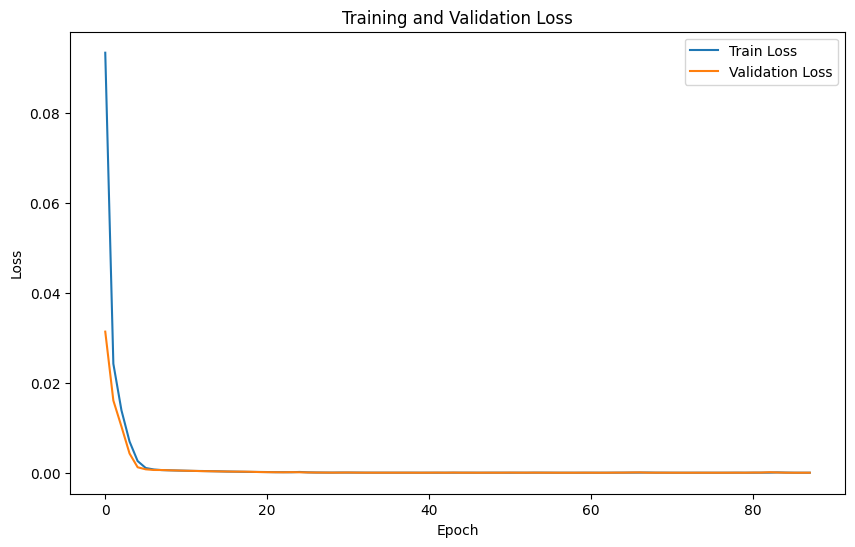

RMSE: 0.002694467082619667
R^2: 0.9998688055393025


In [42]:

#hyperparameters
in_len = 3
hidden_size = 128
num_cells = 2
out_features = 3

model = LSTM(in_len, hidden_size, out_features, num_cells)


# Loss and Optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 100

train(model, num_epochs, train_loader, test_loader, loss_func, optimizer)

plt.figure(figsize=(10,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


evaluate(model, test_loader, loss_func)


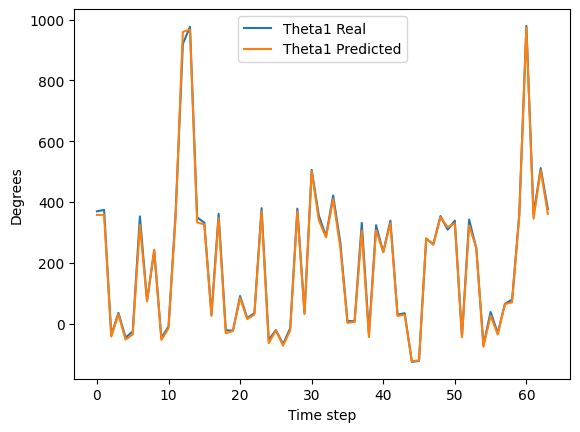

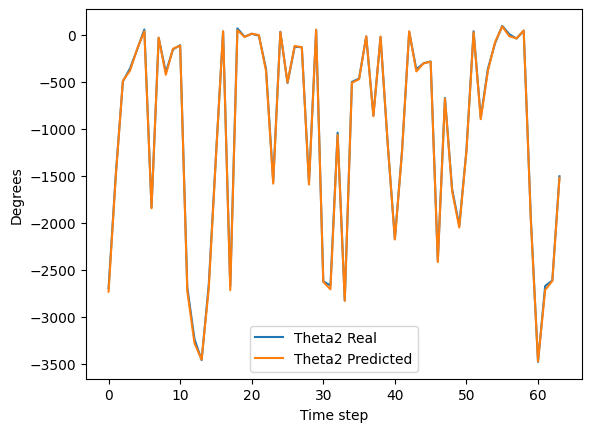

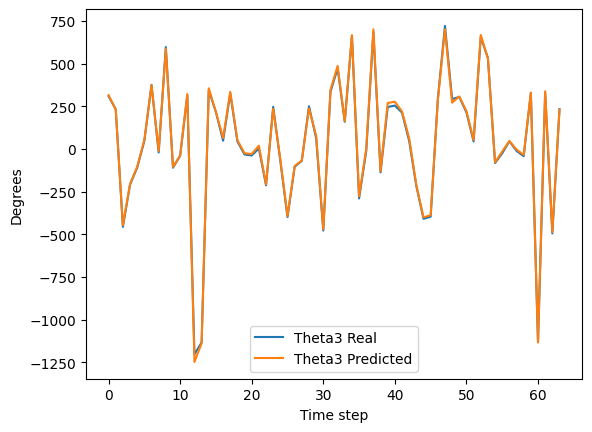

In [32]:
model.eval()
with torch.no_grad():
  for sequences, targets in test_loader:
    y_pred = model(sequences)
    break
  np_pred = y_pred.cpu().numpy()
  np_targets = targets.cpu().numpy()

  y_pred_ori = scaler.inverse_transform(np_pred)
  targets_ori = scaler.inverse_transform(np_targets)

  time_steps_to_plot = min(100, len(targets_ori))

plt.plot(targets_ori[:time_steps_to_plot, 0], label='Theta1 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 0], label='Theta1 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.plot(targets_ori[:time_steps_to_plot, 1], label='Theta2 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 1], label='Theta2 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()

plt.plot(targets_ori[:time_steps_to_plot, 2], label='Theta3 Real')
plt.plot(y_pred_ori[:time_steps_to_plot, 2], label='Theta3 Predicted')
plt.xlabel('Time step')
plt.ylabel('Degrees')
plt.legend()
plt.show()